In [1]:
%load_ext autoreload 
%autoreload 2

In [18]:
from glob import glob 
import pandas as pd 
from fastcore.xtras import load_pickle 

from gptchem.data import get_hea_phase_data
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from gptchem.evaluator import evaluate_classification
from gptchem.formatter import ClassificationFormatter
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH


from scipy.stats import sem

import matplotx
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])
%matplotlib inline


## Get the dummy metrics

In [19]:
data = get_hea_phase_data()

In [20]:
estimators = ['uniform', 'stratified', 'most_frequent']
results = []
train_sizes = [10, 20, 50, 100, 200]
for i in range(10): 
    for estimator in estimators:
        for train_size in train_sizes: 
            train, test = train_test_split(data, train_size=train_size, test_size=250, stratify=data['phase_binary_encoded'], random_state=i) 
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train['Alloy'], train['phase_binary_encoded'])
            predictions = classifier.predict(test['Alloy'])
            res = evaluate_classification(test['phase_binary_encoded'], predictions)
            res['train_size'] = train_size
            res['estimator'] = estimator
            results.append(res)

In [21]:
dummy_results = pd.DataFrame(results)

In [22]:
dummy_grouped = dummy_results[['train_size', 'estimator', 'accuracy', 'f1_macro', 'f1_micro', 'kappa']].groupby([ 'estimator', 'train_size']).agg(['mean', 'std', sem]) 

In [23]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.333333  0.000000   
              20           0.5000  0.000000  0.000000  0.333333  0.000000   
              50           0.5000  0.000000  0.000000  0.333333  0.000000   
              100          0.5000  0.000000  0.000000  0.333333  0.000000   
              200          0.5000  0.000000  0.000000  0.333333  0.000000   
stratified    10           0.5036  0.027159  0.008588  0.503037  0.027244   
              20           0.5092  0.035480  0.011220  0.508548  0.035649   
              50           0.4880  0.045724  0.014459  0.487412  0.046046   
              100          0.5152  0.026385  0.008344  0.514626  0.026420   
              200          0.4844  0.037639  0.011903  0.483574  0.037671   
uniform       10           0.4848  0.024787  0.007838  0.483611  0.025541   
              20           0.5128  0.023911  0.007561  0.512279  0.024157   
              50           0.4956  0.030137  0.009530  0.495154  0.029937   
              100          0.5180  0.034935  0.011047  0.517765  0.034981   
              200          0.4804  0.031858  0.010074  0.479882  0.031917   

                                       f1_micro                       kappa  \
                                   sem     mean       std       sem    mean   
estimator     train_size                                                      
most_frequent 10          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              20          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              50          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              100         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              200         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
stratified    10          8.615207e-03   0.5036  0.027159  0.008588  0.0072   
              20          1.127320e-02   0.5092  0.035480  0.011220  0.0184   
              50          1.456104e-02   0.4880  0.045724  0.014459 -0.0240   
              100         8.354599e-03   0.5152  0.026385  0.008344  0.0304   
              200         1.191247e-02   0.4844  0.037639  0.011903 -0.0312   
uniform       10          8.076721e-03   0.4848  0.024787  0.007838 -0.0304   
              20          7.639182e-03   0.5128  0.023911  0.007561  0.0256   
              50          9.466834e-03   0.4956  0.030137  0.009530 -0.0088   
              100         1.106204e-02   0.5180  0.034935  0.011047  0.0360   
              200         1.009316e-02   0.4804  0.031858  0.010074 -0.0392   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
stratified    10          0.054318  0.017177  
              20          0.070960  0.022440  
              50          0.091448  0.028918  
              100         0.052770  0.016687  
              200         0.075278  0.023805  
uniform       10          0.049574  0.015677  
              20          0.047822  0.015123  
              50          0.060275  0.019061  
              100         0.069870  0.022095  
              200         0.063716  0.020149

## Load the results

In [24]:
all_out = glob("out/**/*.pkl")

In [25]:
all_out = [load_pickle(p) for p in all_out]

In [26]:
extracted_res = []

for out in all_out: 
    res = {
        'base_model': out['base_model'],
        'train_size': out['train_size'],
        'test_size': out['test_size'],
        'n_epochs': out['n_epochs'],
        'learning_rate_multiplier': out['learning_rate_multiplier'],
        'frac_valid': out['frac_valid'],
        'accuracy': out['accuracy'],
        'f1_macro': out['f1_macro'],
        'f1_micro': out['f1_micro'],
        'kappa': out['kappa'],
    }

    extracted_res.append(res)

In [27]:
extracted_res = pd.DataFrame(extracted_res)

In [28]:
extracted_res_grouped = extracted_res.groupby(['train_size']).agg(['mean', 'std', sem])

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_62610/1554210877.py:1: FutureWarning: ['base_model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  extracted_res_grouped = extracted_res.groupby(['train_size']).agg(['mean', 'std', sem])


In [29]:
extracted_res_grouped

test_size           n_epochs           learning_rate_multiplier  \
                mean  std  sem     mean  std  sem                     mean   
train_size                                                                   
10             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
20             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
50             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
100            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
200            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   

                              frac_valid  ...  accuracy  f1_macro            \
            std           sem       mean  ...       sem      mean       std   
train_size                                ...                                 
10          0.0  1.156482e-18        1.0  ...  0.014498  0.884522  0.047488   
20          0.0  1.156482e-18        1.0  ...  0.017266  0.890336  0.056011   
50          0.0  1.156482e-18        1.0  ...  0.010506  0.932225  0.033577   
100         0.0  0.000000e+00        1.0  ...  0.005310  0.960406  0.015974   
200         0.0  1.156482e-18        1.0  ...  0.002696  0.964376  0.008544   

                      f1_micro                         kappa            \
                 sem      mean       std       sem      mean       std   
train_size                                                               
10          0.015017  0.885600  0.045848  0.014498  0.771200  0.091696   
20          0.017712  0.891600  0.054600  0.017266  0.783200  0.109200   
50          0.010618  0.932400  0.033224  0.010506  0.864800  0.066448   
100         0.005325  0.960444  0.015930  0.005310  0.920889  0.031861   
200         0.002702  0.964400  0.008527  0.002696  0.928800  0.017054   

                      
                 sem  
train_size            
10          0.028997  
20          0.034532  
50          0.021013  
100         0.010620  
200         0.005393  

[5 rows x 24 columns]

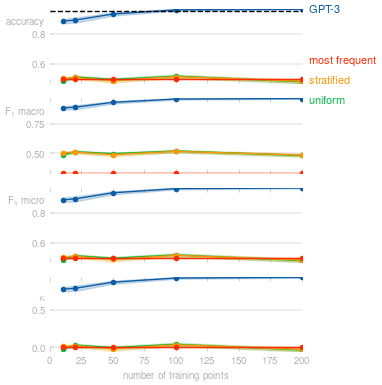

In [30]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex='all')

    # accuracy
    ax[0].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['accuracy']['mean'],
        marker='o',
        label='GPT-3',
    )
    ax[0].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['accuracy']['mean'] - extracted_res_grouped['accuracy']['sem'],
        extracted_res_grouped['accuracy']['mean'] + extracted_res_grouped['accuracy']['sem'],
        alpha=.2,
        color='C0',
    )
    

    #add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[0].plot(
            dummy_grouped.loc[estimator, :]['accuracy']['mean'].index,
            dummy_grouped.loc[estimator, :]['accuracy']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[0].fill_between(
            dummy_grouped.loc[estimator, :]['accuracy']['mean'].index,
            dummy_grouped.loc[estimator, :]['accuracy']['mean'] - dummy_grouped.loc[estimator, :]['accuracy']['sem'],
            dummy_grouped.loc[estimator, :]['accuracy']['mean'] + dummy_grouped.loc[estimator, :]['accuracy']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )

    # f1 macro 
    ax[1].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['f1_macro']['mean'],
        label='GPT-3',
        marker='o',
    )
    ax[1].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['f1_macro']['mean'] - extracted_res_grouped['f1_macro']['sem'],
        extracted_res_grouped['f1_macro']['mean'] + extracted_res_grouped['f1_macro']['sem'],
        alpha=.2,
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[1].plot(
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[1].fill_between(
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'] - dummy_grouped.loc[estimator, :]['f1_macro']['sem'],
            dummy_grouped.loc[estimator, :]['f1_macro']['mean'] + dummy_grouped.loc[estimator, :]['f1_macro']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )

    # f1 micro 

    ax[2].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['f1_micro']['mean'],
        label='GPT-3',
        marker='o',
    )
    ax[2].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['f1_micro']['mean'] - extracted_res_grouped['f1_micro']['sem'],
        extracted_res_grouped['f1_micro']['mean'] + extracted_res_grouped['f1_micro']['sem'],
        alpha=.2,
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[2].plot(
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[2].fill_between(
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'].index,
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'] - dummy_grouped.loc[estimator, :]['f1_micro']['sem'],
            dummy_grouped.loc[estimator, :]['f1_micro']['mean'] + dummy_grouped.loc[estimator, :]['f1_micro']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )


    # kappa
    ax[3].plot(
        extracted_res_grouped.index, 
        extracted_res_grouped['kappa']['mean'],
        label='GPT-3',
        marker='o',
    )
    ax[3].fill_between(
        extracted_res_grouped.index,
        extracted_res_grouped['kappa']['mean'] - extracted_res_grouped['kappa']['sem'],
        extracted_res_grouped['kappa']['mean'] + extracted_res_grouped['kappa']['sem'],
        alpha=.2,
        color='C0',
    )

    # add the dummy models 
    for i, estimator in enumerate(estimators):
        ax[3].plot(
            dummy_grouped.loc[estimator, :]['kappa']['mean'].index,
            dummy_grouped.loc[estimator, :]['kappa']['mean'],
            label=estimator.replace('_', ' '),
            marker='o',
            color=f'C{i+1}'
        )
        ax[3].fill_between(
            dummy_grouped.loc[estimator, :]['kappa']['mean'].index,
            dummy_grouped.loc[estimator, :]['kappa']['mean'] - dummy_grouped.loc[estimator, :]['kappa']['sem'],
            dummy_grouped.loc[estimator, :]['kappa']['mean'] + dummy_grouped.loc[estimator, :]['kappa']['sem'],
            alpha=.2,
            color=f'C{i+1}',
        )

    ax[0].hlines(0.95, 0, 200, color='k', linestyle='--')

    matplotx.ylabel_top('accuracy', ax=ax[0])
    matplotx.ylabel_top(r'F$_{1}$ macro', ax=ax[1])
    matplotx.ylabel_top(r'F$_{1}$ micro', ax=ax[2])
    matplotx.ylabel_top(r'$\kappa$', ax=ax[3])
    ax[-1].set_xlabel('number of training points', labelpad=4)
    matplotx.line_labels(ax[0], fontsize=8)
    fig.savefig('hea_single_vs_multiphase_classifier.pdf', bbox_inches='tight')

In [15]:
dummy_grouped

accuracy            f1_macro           f1_micro  \
                             mean       std      mean       std     mean   
estimator     train_size                                                   
most_frequent 10           0.5000  0.000000  0.333333  0.000000   0.5000   
              20           0.5000  0.000000  0.333333  0.000000   0.5000   
              50           0.5000  0.000000  0.333333  0.000000   0.5000   
              100          0.5000  0.000000  0.333333  0.000000   0.5000   
              200          0.5000  0.000000  0.333333  0.000000   0.5000   
stratified    10           0.4888  0.030568  0.488146  0.030612   0.4888   
              20           0.5132  0.028224  0.512246  0.029009   0.5132   
              50           0.4996  0.034690  0.499076  0.034555   0.4996   
              100          0.5024  0.040009  0.501453  0.040153   0.5024   
              200          0.5028  0.022075  0.502295  0.022070   0.5028   
uniform       10           0.4932  0.027587  0.492865  0.027662   0.4932   
              20           0.4916  0.019727  0.491115  0.019571   0.4916   
              50           0.5040  0.023171  0.503654  0.023298   0.5040   
              100          0.4968  0.036554  0.496159  0.036845   0.4968   
              200          0.4728  0.025703  0.471963  0.025709   0.4728   

                                     kappa            
                               std    mean       std  
estimator     train_size                              
most_frequent 10          0.000000  0.0000  0.000000  
              20          0.000000  0.0000  0.000000  
              50          0.000000  0.0000  0.000000  
              100         0.000000  0.0000  0.000000  
              200         0.000000  0.0000  0.000000  
stratified    10          0.030568 -0.0224  0.061136  
              20          0.028224  0.0264  0.056449  
              50          0.034690 -0.0008  0.069379  
              100         0.040009  0.0048  0.080018  
              200         0.022075  0.0056  0.044149  
uniform       10          0.027587 -0.0136  0.055175  
              20          0.019727 -0.0168  0.039454  
              50          0.023171  0.0080  0.046342  
              100         0.036554 -0.0064  0.073108  
              200         0.025703 -0.0544  0.051405

In [26]:
dummy_grouped.loc['most_frequent']

accuracy       f1_macro      f1_micro      kappa     
               mean  std      mean  std     mean  std  mean  std
train_size                                                      
10              0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
20              0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
50              0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
100             0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0
200             0.5  0.0  0.333333  0.0      0.5  0.0   0.0  0.0